In [1]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

In [2]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
        pred = output >= 0.5 
        correct += pred.eq(target.view_as(pred)).sum().item()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item(), 100. * correct / len(train_loader.dataset)

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    #     name, test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [3]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    resNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

In [4]:
%%time
from random import randint

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

accs_val = []
loss_val = []
seed = randint(0,50)
prng = RandomState(seed)
random_permute = prng.permutation(np.arange(0, 1000))
train_top = 10//n_classes
val_top = 1000//n_classes
indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

train_data = Subset(train_dataset, indx_train)
val_data = Subset(val_dataset, indx_val)

print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32, 
                                            shuffle=True)

val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=128, 
                                            shuffle=False)

model = resNet18()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for epoch in range(50):
    l, a = train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    loss_val.append(l)
    accs_val.append(a)

print('Val set: %.2f'%(test(model, device, val_loader)), '%')
     

Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 0 [0/10 (0%)]	Loss: 0.879212
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000396
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000178
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000088
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000055
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000044
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000038
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000029
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000026


c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: 70.50 %
CPU times: total: 18.5 s
Wall time: 12.3 s


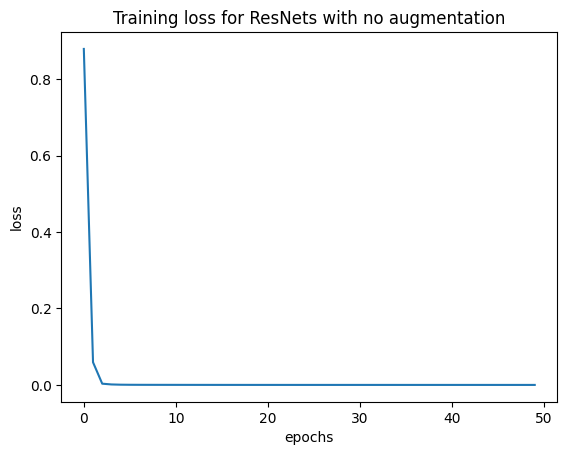

In [5]:
import matplotlib.pyplot as pltx

plt.plot(loss_val)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss for ResNets with no augmentation');
plt.savefig('noaugment_loss.png')

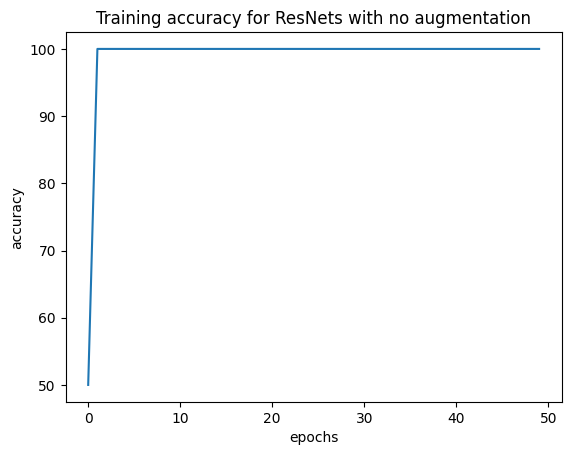

In [6]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training accuracy for ResNets with no augmentation');
plt.savefig('noaugment_accuracy.png')

In [7]:
%%time
from torchvision.transforms.autoaugment import RandAugment
from random import randint

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

trn_transform = transforms.Compose([transforms.RandAugment(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

val_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=trn_transform, download=download)
val_dataset = DataClass(split='train', transform=val_transform, download=download)

accs_val = []
loss_val = []
seed = randint(0,50)
prng = RandomState(seed)
random_permute = prng.permutation(np.arange(0, 1000))
train_top = 10//n_classes
val_top = 1000//n_classes
indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

train_data = Subset(train_dataset, indx_train)
val_data = Subset(val_dataset, indx_val)

print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32, 
                                            shuffle=True)

val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=128, 
                                            shuffle=False)

model = resNet18()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for epoch in range(50):
    l, a = train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    loss_val.append(l)
    accs_val.append(a)

print('Val set: %.2f'%(test(model, device, val_loader)), '%')
     

Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 0 [0/10 (0%)]	Loss: 0.947969
Train Epoch: 5 [0/10 (0%)]	Loss: 1.084863
Train Epoch: 10 [0/10 (0%)]	Loss: 0.489529
Train Epoch: 15 [0/10 (0%)]	Loss: 1.428828
Train Epoch: 20 [0/10 (0%)]	Loss: 0.448613
Train Epoch: 25 [0/10 (0%)]	Loss: 0.912622
Train Epoch: 30 [0/10 (0%)]	Loss: 0.273560
Train Epoch: 35 [0/10 (0%)]	Loss: 0.172971
Train Epoch: 40 [0/10 (0%)]	Loss: 0.069175
Train Epoch: 45 [0/10 (0%)]	Loss: 1.371119


c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: 90.40 %
CPU times: total: 24.3 s
Wall time: 12.9 s


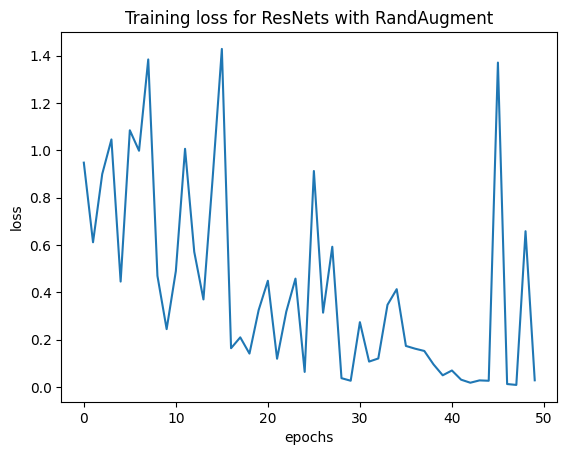

In [8]:
import matplotlib.pyplot as plt

plt.plot(loss_val)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss for ResNets with RandAugment');
plt.savefig('randaugment_loss.png')

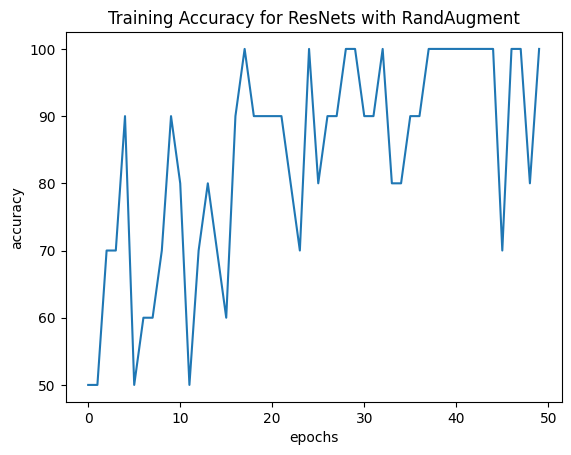

In [9]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy for ResNets with RandAugment');
plt.savefig('randaugment_acc.png')

In [10]:
%%time
from torchvision.transforms.autoaugment import TrivialAugmentWide
from random import randint

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

trn_transform = transforms.Compose([transforms.TrivialAugmentWide(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[.5], std=[.5])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=trn_transform, download=download)
val_dataset = DataClass(split='train', transform=val_transform, download=download)

accs_val = []
loss_val = []
seed = randint(0,50)
prng = RandomState(seed)
random_permute = prng.permutation(np.arange(0, 1000))
train_top = 10//n_classes
val_top = 1000//n_classes
indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

train_data = Subset(train_dataset, indx_train)
val_data = Subset(val_dataset, indx_val)

print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32, 
                                            shuffle=True)

val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=128, 
                                            shuffle=False)

model = resNet18()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for epoch in range(50):
    l, a = train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    loss_val.append(l)
    accs_val.append(a)

print('Val set: %.2f'%(test(model, device, val_loader)), '%')
     

Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.777241
Train Epoch: 5 [0/10 (0%)]	Loss: 0.553356
Train Epoch: 10 [0/10 (0%)]	Loss: 0.413153
Train Epoch: 15 [0/10 (0%)]	Loss: 0.527554
Train Epoch: 20 [0/10 (0%)]	Loss: 0.470439
Train Epoch: 25 [0/10 (0%)]	Loss: 0.721849
Train Epoch: 30 [0/10 (0%)]	Loss: 0.510655
Train Epoch: 35 [0/10 (0%)]	Loss: 0.520720
Train Epoch: 40 [0/10 (0%)]	Loss: 0.222554
Train Epoch: 45 [0/10 (0%)]	Loss: 0.096953
Val set: 90.30 %
CPU times: total: 21.7 s
Wall time: 12.5 s


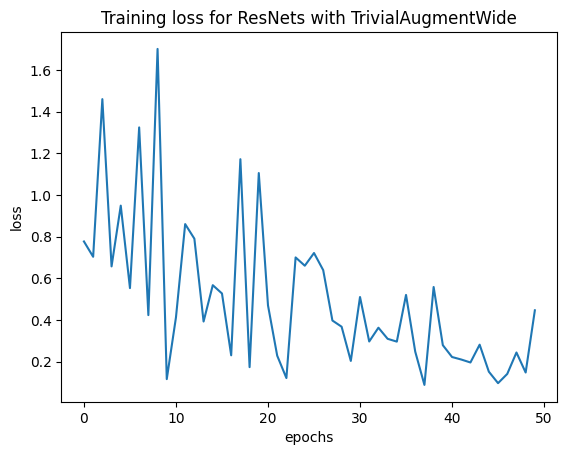

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_val)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss for ResNets with TrivialAugmentWide');
plt.savefig('trivialaugment_loss.png')

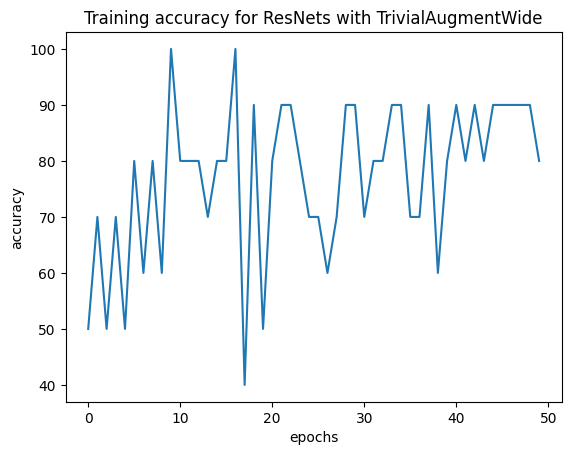

In [12]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training accuracy for ResNets with TrivialAugmentWide');
plt.savefig('trivialaugment_accuracy.png')